In [1]:
import os, sys
import torch
import signal
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "true"
from main import Main__

model_config = {'amp':True, 'use_distributed':False,'accum_grad_iters':1,
                'model_mission':'caption_detection' ,# caption, caption_detection
                'batch_size':8,
                'chat_template': True, 
                'end_sym': [
                    '\n {} </s>',
                    "\n <|start_header_id|>assistant<|end_header_id|> {} <|eot_id|>"
                ],# list[0] = llama2, list[1] = llama3
                'prompt_template': [
                "<s>[INST] {} [/INST]", 
                """<|begin_of_text|><|start_header_id|>user<|end_header_id|> {} <|eot_id|>"""
                ],# list[0] = llama2, list[1] = llama3
                'max_txt_len': 1024, 'max_context_len': 3500,
                # 'ouput_dir': './model_FT_weight/llama3_vit_L-clip336', #./llama3_vit_L-clip336, ./llama3_vit_B-clip224-b16
                'ouput_dir': './model_FT_weight/llama3_tw_vit_L-clip336[detection]', #./llama3_vit_L-clip336, ./llama3_vit_B-clip224-b16
                # 'ouput_dir': './demo', #./llama3_vit_L-clip336, ./llama3_vit_B-clip224-b16
                'stage_ckpt': '/ssd3/chih/LLM/MiniGPT-4-ckpt/checkpoint_stage3.pth', 
                'vis_root_train': '/ssd3/chih/Dataset/VISION-Datasets/minigpt_/train/coco/image/train', # './dataset/minigpt_casing_train/coco/image/train'
                'ann_paths_train': ['/ssd3/chih/Dataset/VISION-Datasets/minigpt_/train/coco_caption/defe_ready_anno.json'], # ['./dataset/minigpt_casing_train/coco_caption/defe_ready_anno.json']
                'vis_root_valid': '/ssd3/chih/Dataset/VISION-Datasets/minigpt_/test/coco/image/test', # './dataset/minigpt_casing_test/coco/image/test'
                'ann_paths_valid': ['/ssd3/chih/Dataset/VISION-Datasets/minigpt_/test/coco_caption/defe_ready_anno.json'] # ['./dataset/minigpt_casing_test/coco_caption/defe_ready_anno.json']
                }

# llm_config = {'llama_model':'/ssd3/chih/LLM/Llama-2-7b-chat-hf', 'low_resource':True, 'low_res_device':0, 
#               'lora_r':64, 'lora_target_modules':["q_proj", "v_proj"], 'lora_alpha':16,'lora_dropout':0.05
#               }
# llm_config = {'llama_model':'/ssd3/chih/LLM/Meta-Llama-3-8B-Instruct', 'low_resource':True, 'low_res_device':0, 
#               'lora_r':64, 'lora_target_modules':["q_proj", "v_proj"], 'lora_alpha':16,'lora_dropout':0.05
#               }
llm_config = {'llama_model':'/ssd3/chih/LLM/Llama-3-Taiwan-8B-Instruct-DPO', 'low_resource':True, 'low_res_device':0, 
              'lora_r':64, 'lora_target_modules':["q_proj", "v_proj"], 'lora_alpha':16,'lora_dropout':0.05
              }
# '/ssd3/chih/LLM/Meta-Llama-3-8B-Instruct'


vit_config = {'model_name':'clip_large_336', #eva_clip_g, clip_large_336
            #   'model_path':"../../VITModel/clip-vit-base-patch16", #clip-vit-base-patch16, clip-vit-large-patch14-336
              'model_path':"../../VITModel/clip-vit-large-patch14-336", #clip-vit-base-patch16, clip-vit-large-patch14-336
            #   'image_size': 224,  #bilp2 = 448, clip = 224 or 336
              'image_size': 336,  #bilp2 = 448, clip = 224 or 336
              'drop_path_rate': 0, 'use_grad_checkpoint': True, 'vit_precision': 'fp16', 'freeze_vit': True, }

lr_config = {'init_lr': 1e-5, 'beta2':0.999,'min_lr': 1e-6, 'decay_rate': None, 'weight_decay':0.05,
                'warmup_start_lr': 1e-6, 'warmup_steps': 1000, 'iters_per_epoch': 1000}


main_ = Main__(model_config=model_config)
main_.VLM_build(llm_config=llm_config, vit_config=vit_config)

Loading LLAMA


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tokenizer pass


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 27,262,976 || all params: 8,057,540,608 || trainable%: 0.3384


/ssd3/chih/miniconda3/envs/minigptv/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
from utils.caption_datasets import COCOCaptionDataset
from torch.utils.data import DataLoader
# demo測試對話反饋
train_data_set = COCOCaptionDataset(vis_root = model_config['vis_root_valid'], 
                                ann_paths = model_config['ann_paths_valid'],
                                img_size = vit_config['image_size'],
                                model_mission=model_config['model_mission'])
dataloader = DataLoader(train_data_set, batch_size=1, shuffle=True, pin_memory=True)
ckpt_url = '/ssd3/chih/branch/VLM_Rebuild/model_FT_weight/llama3_tw_vit_L-clip336[detection]/checkpoint_best.pth' 
main_.load_checkpoint(ckpt_url=ckpt_url)

ann paths ['/ssd3/chih/Dataset/VISION-Datasets/minigpt_/test/coco_caption/defe_ready_anno.json']
{'caption': '這是「Electronics」產品。「左下」有瑕疵問題。', 'image': '/ssd3/chih/Dataset/VISION-Datasets/minigpt_/test/coco/image/test/Electronics_000036.jpg', 'image_id': 'Electronics_000036.jpg', 'category': 'Electronics', 'category_id': 0, 'bbox': [[53, 391, 79, 79]], 'instance_id': '0'}
/ssd3/chih/Dataset/VISION-Datasets/minigpt_/test/coco/image/test/Lens_000128.jpg 

[Total]:  1014


In [3]:
main_.model.llama_model.generation_config.pad_token_id = main_.model.llama_tokenizer.pad_token_id

In [4]:
import re
# ====================Prompt Format====================
patterns = ["Llama-3", "Llama3", "llama3", "llama-3"]
pattern = re.compile("|".join(patterns), flags=re.IGNORECASE)
if pattern.search(main_.llm_config['llama_model']):
    main_.prompt_template = main_.prompt_template[1]
    main_.end_sym = main_.end_sym[1]
else:
    main_.prompt_template = main_.prompt_template[0]
    main_.end_sym = main_.end_sym[0]
# ========================================================

In [25]:
import cv2
import matplotlib.pylab as plt
import numpy as np
def image_show(samples):
    image_path = samples['image_path'][0]
    image = cv2.imread(image_path)
    H,W,C = image.shape
    # print(H,W,C )
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    stick_stack = []
    bbox_ = np.array(samples['bbox']).squeeze(-1)
    for box in bbox_:
        x, y, w, h = box[0], box[1], box[2], box[3]
        cv2.rectangle(image_rgb, (int(x), int(y)), ((int(x+w), int(y+h))), (255,0,0), 5, cv2.LINE_AA)
    cv2.line(image_rgb, (0,H//2), (W,H//2), (0,0,255), 7)
    cv2.line(image_rgb, (W//2,0), (W//2,H), (0,0,255), 7)
    plt.imshow(image_rgb)
    plt.axis('off')  # 不顯示坐標軸
    plt.show()

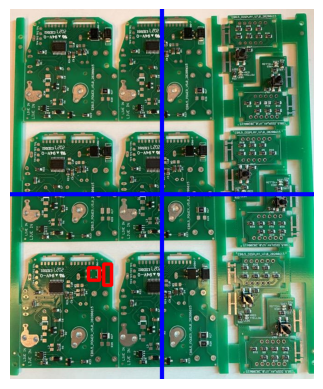

Q:  請指出這是什麼產品以及哪邊有瑕疵。  <|eot_id|>
A(預測答案): ['這是「pcb_2」產品。「左上」、「左下」有瑕疵問題。']
G(真實答案): ['這是「pcb_2」產品。「左下」有瑕疵問題。']


In [34]:
samples = next(iter(dataloader))
samples['image'] = samples['image'].cuda()
image_show(samples)
ans = main_.chat_module(samples=samples)
ans = [text.split("<|end_header_id|> ")[1].replace(" <|eot_id|>","") for text in ans]
# print("讀取使用fine tune後的llama3權重直接輸出 [同資料集finetune]")
print("Q:",samples['instruction_input'][0].split("[detection]")[1], )
print("A(預測答案):",ans)
print("G(真實答案):",samples['answer'])